In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

#read data
df = pd.read_excel('T_max.xlsx',index_col="YEAR") 
df = df.dropna()
data = df["T_max"]

# Display of Data

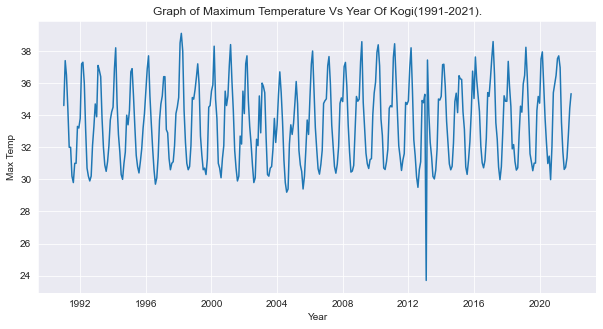

In [2]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.set_style('darkgrid')
plt.xlabel('Year')
plt.ylabel('Max Temp')
plt.title('Graph of Maximum Temperature Vs Year Of Kogi(1991-2021).')
plt.plot(data)

In [3]:
Average_per_year = data.resample('MS').sum()

# Decomposing the result

<Figure size 432x288 with 0 Axes>

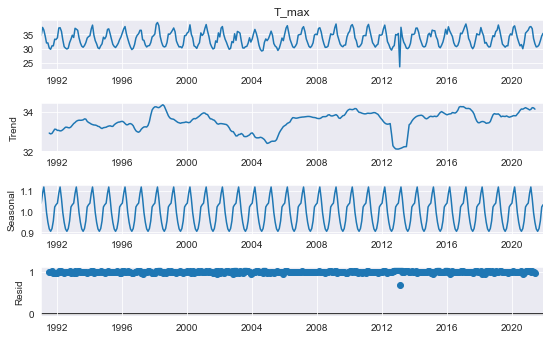

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition1 = seasonal_decompose(Average_per_year, model = 'multiplicative')# model additive, period= 30
fig = plt.figure()
fig = decomposition1.plot()
fig.set_size_inches(8,5)

# Checking for Stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    output = pd.Series(dftest[0:4], index = ['Test Statistics','p-value','No. of lags used','No. of observations used'])
    for key, val in dftest[4].items():
        output['Critical value (%s)'%key] = val
    print(output)
adf_test(data)

Test Statistics              -3.921650
p-value                       0.001881
No. of lags used             17.000000
No. of observations used    354.000000
Critical value (1%)          -3.448958
Critical value (5%)          -2.869739
Critical value (10%)         -2.571138
dtype: float64


# Futher studies

In [ ]:
def futherStudies(dataset):
    moving_average = dataset.rolling(12).mean()
    moving_std = dataset.rolling(12).std()
    plt.figure(figsize=(15,9))
    plt.plot(dataset, color ='blue',label ='Original')
    plt.plot(moving_average, color ='red',label ='Rolling mean')
    plt.plot(moving_std, color ='black',label ='Rolling std')
    plt.legend(loc = "best")
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
futherStudies(data)

# ACF and PACF plots

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


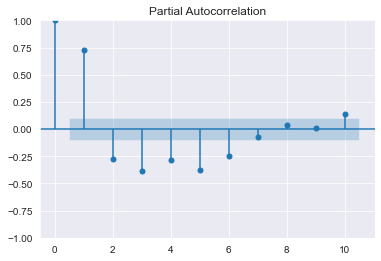

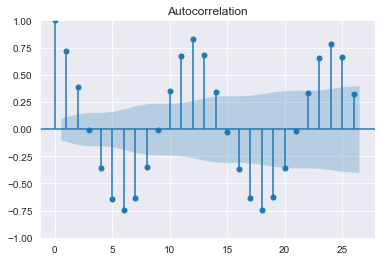

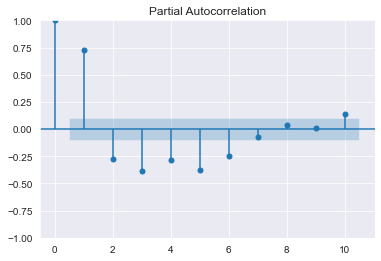

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(Average_per_year)
plot_pacf(Average_per_year,lags = 10)

# Train-Test Split

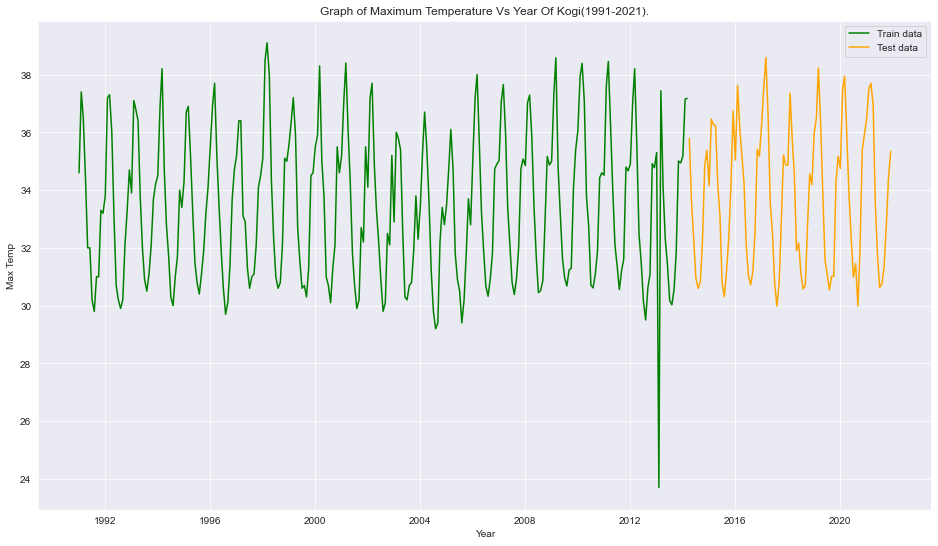

In [7]:
train_data, test_data = data[:int(len(data)*0.75)], data[int(len(data)*0.75):]
plt.figure(figsize = (16,9))
plt.xlabel('Year')
plt.ylabel('Max Temp')
plt.title('Graph of Maximum Temperature Vs Year Of Kogi(1991-2021).')
plt.plot(train_data, 'green', label = 'Train data')
plt.plot(test_data, 'orange', label = 'Test data')
plt.legend(loc = 'best')

# Apply auto_arima function

In [ ]:
from pmdarima import auto_arima
#ignores harmless warnings
import warnings
warnings.filterwarnings("ignore")

orders = auto_arima(data, n=1,  max_p=7, max_q=7, seasonal=False,
                          start_p=0,start_q=0,trace=True,error_action ='ignore',
                          suppress_warnings=True, stepwise=True)
orders.summary()

# ARIMA model

In [8]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_data,order=(2,0,2)) #Obtain the order from the auto_arima function in the above code
fitted=model.fit()
#model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


# Residual Error

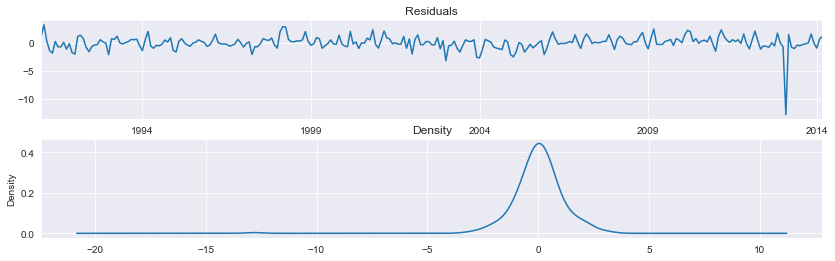

count    279.000000
mean       0.010175
std        1.253652
min      -12.808621
25%       -0.479452
50%        0.014775
75%        0.572554
max        3.209088
dtype: float64


In [9]:
residuals =fitted.resid
fig, ax = plt.subplots(2,1)
fig.set_size_inches(14,4)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())

# Model predictions

In [ ]:
test_data.shape

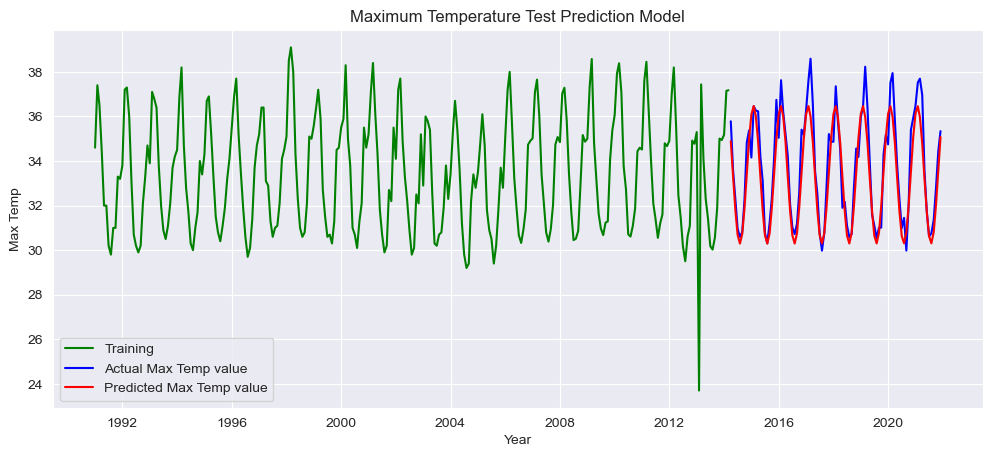

In [10]:
fc = fitted.forecast(93,alpha =0.15) # you should find the x region with the size of the test_data
conf = fitted.forecast(93,alpha =0.15)
se = fitted.forecast(93,alpha =0.15)
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:], index = test_data.index)
upper_series = pd.Series(conf[:], index = test_data.index)
plt.figure(figsize=(12,5), dpi =100)
plt.plot(train_data, color='g', label ='Training')
plt.plot(test_data, color ='blue', label ='Actual Max Temp value')
plt.plot(fc_series, color ='r', label ='Predicted Max Temp value')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.05)
plt.title('Maximum Temperature Test Prediction Model')
plt.xlabel('Year')
plt.ylabel('Max Temp')
plt.legend(loc='best', fontsize=10) #you can use loc = 'upper left'
plt.show()

# Performance of the model

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(test_data, fc)
print('MSE : '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE : '+str(mae))
rmse = sqrt(mse)
print('RMSE : '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE : '+str(mape))

MSE : 0.8875664007631163
MAE : 0.7230572978757235
RMSE : 0.9421074252775616
MAPE : 0.020830320436421617


# Predict future data

In [12]:
final_model = ARIMA(Average_per_year,order =(2,0,2)).fit()
prediction = final_model.predict(len(Average_per_year),len(Average_per_year)+24)

prediction.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2022-01-01    36.220276
2022-02-01    36.655654
2022-03-01    36.246552
2022-04-01    35.102711
2022-05-01    33.530907
Freq: MS, Name: predicted_mean, dtype: float64

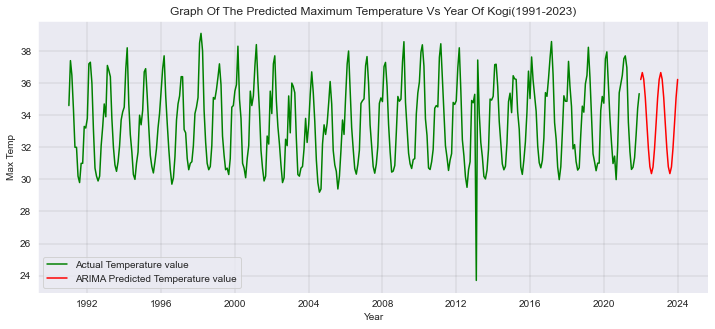

In [13]:
plt.figure(figsize=(12,5)) #dpi =100
plt.grid(True, color = 'k', linewidth=0.1)
plt.plot(Average_per_year, color ='g', label ='Actual Temperature value')
plt.plot(prediction, color ='r', label ='ARIMA Predicted Temperature value')
plt.xlabel('Year')
plt.ylabel('Max Temp')
plt.title('Graph Of The Predicted Maximum Temperature Vs Year Of Kogi(1991-2023)')
plt.legend(loc='best', fontsize=10)
plt.show()

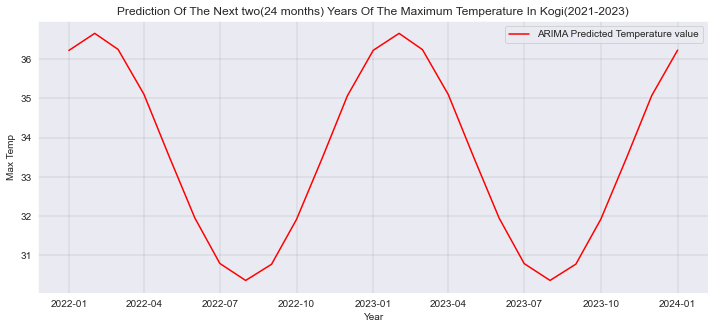

In [14]:
plt.figure(figsize=(12,5))
plt.grid(True, color = 'k', linewidth=0.1)
plt.plot(prediction, color ='r', label ='ARIMA Predicted Temperature value')
plt.xlabel('Year')
plt.ylabel('Max Temp')
plt.title('Prediction Of The Next two(24 months) Years Of The Maximum Temperature In Kogi(2021-2023)')
plt.legend(loc='best', fontsize=10)
plt.show()